### NVK Tea Production and Sales Analysis

In [22]:
# 1. Setup & Imports
# Purpose: Load required Python libraries for data manipulation, visualization, time series analysis, and modeling.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.linear_model import LinearRegression
import warnings
import os

In [23]:
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)

In [24]:
#load dataset
df = pd.read_csv('nvk_production.csv', parse_dates=['Date'])
df.columns = [c.strip() for c in df.columns]
df = df.set_index('Date').sort_index()
df.head()


,GREEN LEAF (Kg),MADE TEA (Kg),NETT OUT TURN,NETT SALE AVERAGE (Rs),LOW GROWN AVERAGE (Rs),DIFFERENCE (Rs),BOUGHT LEAF RATE (Rs)
Date,,,,,,,
1997-04-30,417935,94143.0,22.53,145.17,120.31,24.86,20.76
1997-05-31,510033,109461.0,21.46,150.33,129.36,20.97,21.70
1997-06-30,436533,97275.0,22.28,160.32,135.69,24.63,23.10
1997-07-31,475422,98949.0,20.81,158.19,131.57,26.62,22.70
1997-08-31,441680,97419.0,22.06,161.18,138.90,22.28,23.50


In [25]:
# data exploration

print('Data range:', df.index.min(), 'to', df.index.max())
print('\nColumn dtype info:')
print(df.dtypes)
print('\nMissing values per column:')
print(df.isna().sum())

Data range: 1997-04-30 00:00:00 to 2023-07-31 00:00:00

Column dtype info:
GREEN LEAF (Kg)             int64
MADE TEA (Kg)             float64
NETT OUT TURN             float64
NETT SALE AVERAGE (Rs)    float64
LOW GROWN AVERAGE (Rs)    float64
DIFFERENCE (Rs)           float64
BOUGHT LEAF RATE (Rs)     float64
dtype: object

Missing values per column:
GREEN LEAF (Kg)           0
MADE TEA (Kg)             0
NETT OUT TURN             0
NETT SALE AVERAGE (Rs)    0
LOW GROWN AVERAGE (Rs)    0
DIFFERENCE (Rs)           0
BOUGHT LEAF RATE (Rs)     1
dtype: int64


In [26]:
# 3. Data Cleaning & Type Conversion
# Purpose: Ensure numeric columns are correctly typed, handle commas/Rs symbols, and interpolate missing values.
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype(str).str.replace(',', '').str.replace('Rs', '').str.strip()
        df[col] = pd.to_numeric(df[col], errors='coerce')


numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_cols:
    df[col] = df[col].interpolate(method='time', limit=12)


print('\nMissing values after interpolation:')
print(df.isna().sum())


Missing values after interpolation:
GREEN LEAF (Kg)           0
MADE TEA (Kg)             0
NETT OUT TURN             0
NETT SALE AVERAGE (Rs)    0
LOW GROWN AVERAGE (Rs)    0
DIFFERENCE (Rs)           0
BOUGHT LEAF RATE (Rs)     0
dtype: int64


In [27]:
# 4. Summary Statistics
# Purpose: Provide descriptive statistics (min, max, mean, median, std, coefficient of variation) for all numeric columns.
summary = df.describe().T
summary['median'] = df.median()
summary['cv'] = (summary['std'] / summary['mean']).replace([np.inf, -np.inf], np.nan)
display(summary)
summary.to_csv('summary_statistics.csv')

,count,mean,std,min,25%,50%,75%,max,median,cv
GREEN LEAF (Kg),316.0,617772.202532,124931.300808,219222.00,524681.5000,624874.500,704669.2500,874851.00,624874.500,0.202229
MADE TEA (Kg),316.0,131543.454114,24519.161723,51224.00,114618.3750,133316.500,149862.5000,187893.00,133316.500,0.186396
NETT OUT TURN,316.0,21.375538,0.784540,18.46,20.8500,21.395,21.8425,23.73,21.395,0.036703
NETT SALE AVERAGE (Rs),316.0,481.917247,357.192608,145.17,204.2550,445.945,653.6975,2184.43,445.945,0.741191
LOW GROWN AVERAGE (Rs),316.0,417.246835,308.193115,106.48,169.7600,382.870,547.6075,1763.45,382.870,0.738635
DIFFERENCE (Rs),316.0,64.670411,53.704538,14.57,30.4125,50.285,76.7925,420.98,50.285,0.830434
BOUGHT LEAF RATE (Rs),316.0,67.745728,49.951551,20.76,28.3750,62.525,91.3300,302.25,62.525,0.737339


In [28]:
# 5. Derived Metrics
# Purpose: Compute key performance metrics like Nett Out Turn Ratio and Profit per Kg.
df['OUTTURN_RATIO'] = df['MADE TEA (Kg)'] / df['GREEN LEAF (Kg)']
df['PROFIT_PER_KG'] = df['NETT SALE AVERAGE (Rs)'] - df['BOUGHT LEAF RATE (Rs)']


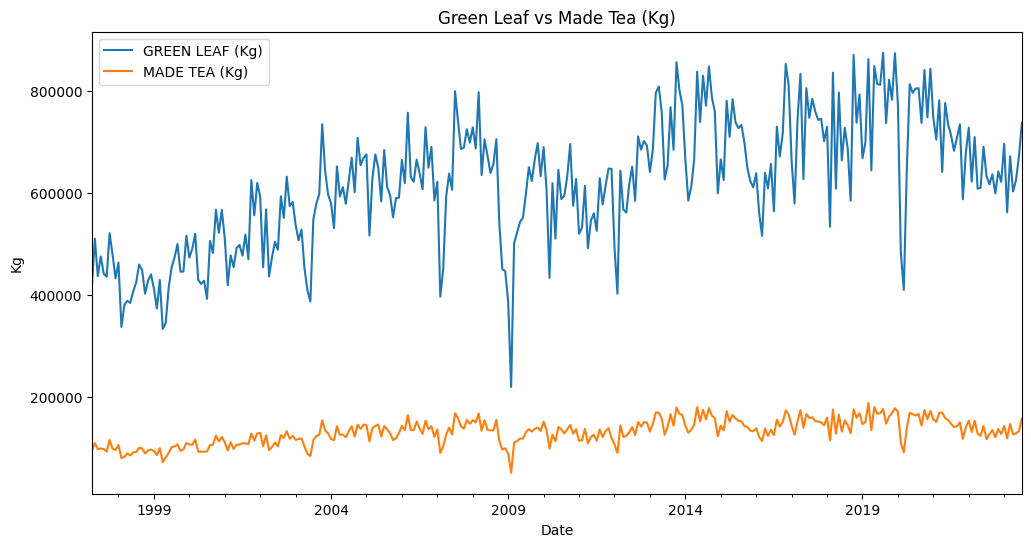

In [29]:
# 6. Production Trends
# Purpose: Visualize the trend of Green Leaf and Made Tea volumes over time.
df[['GREEN LEAF (Kg)', 'MADE TEA (Kg)']].plot(title='Green Leaf vs Made Tea (Kg)')
plt.ylabel('Kg')
plt.show()

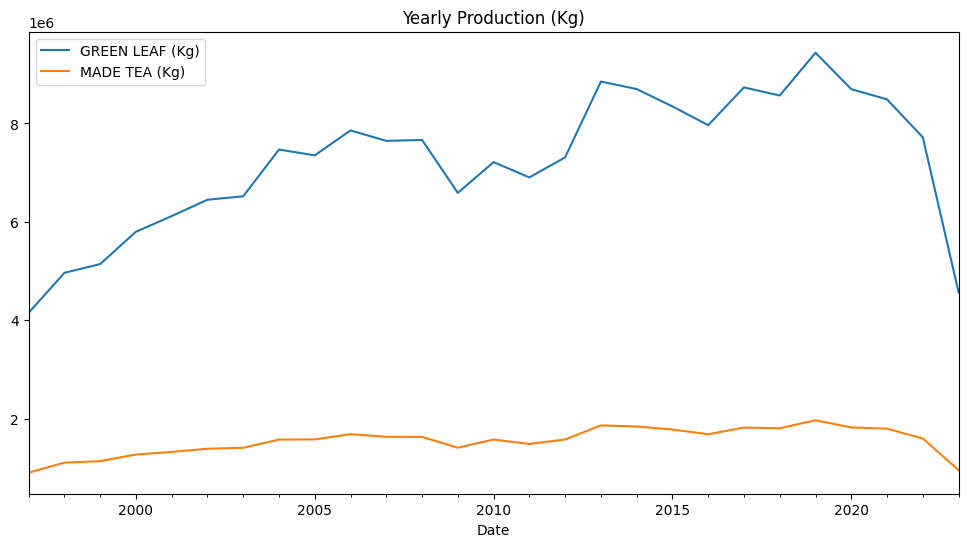

In [30]:
yearly = df[['GREEN LEAF (Kg)', 'MADE TEA (Kg)']].resample('Y').sum()
yearly.plot(title='Yearly Production (Kg)')
plt.show()

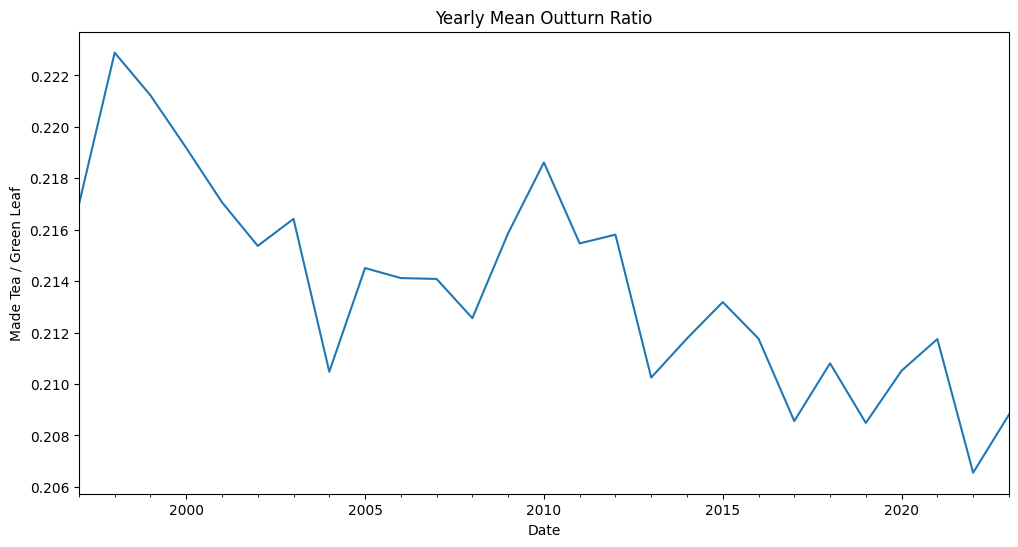

In [31]:
# 7. Efficiency Trends
# Purpose: Analyze the Nett Out Turn Ratio over the years.
df['OUTTURN_RATIO'].resample('Y').mean().plot(title='Yearly Mean Outturn Ratio')
plt.ylabel('Made Tea / Green Leaf')
plt.show()

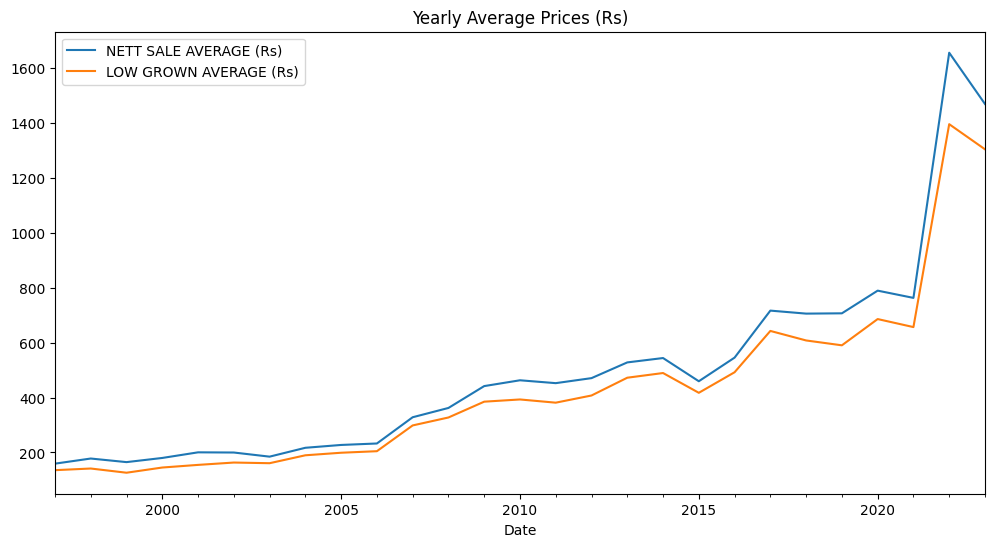

In [32]:
# 8. Price Trends
# Purpose: Compare factory Nett Sale Average vs Low Grown Average.
df[['NETT SALE AVERAGE (Rs)', 'LOW GROWN AVERAGE (Rs)']].resample('Y').mean().plot(title='Yearly Average Prices (Rs)')
plt.show()

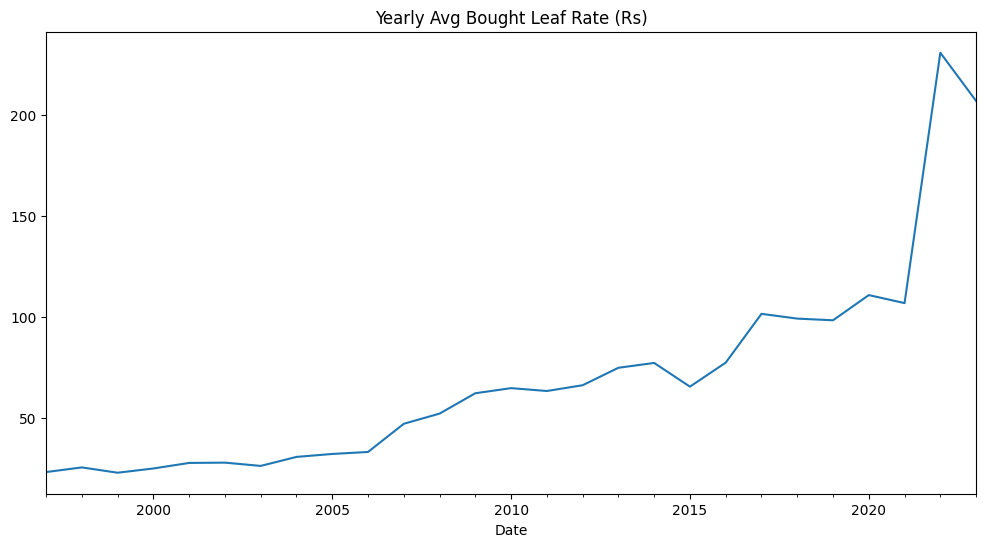

In [33]:
# 9. Cost Trends
# Purpose: Analyze fluctuations in Bought Leaf Rate over time.
df['BOUGHT LEAF RATE (Rs)'].resample('Y').mean().plot(title='Yearly Avg Bought Leaf Rate (Rs)')
plt.show()

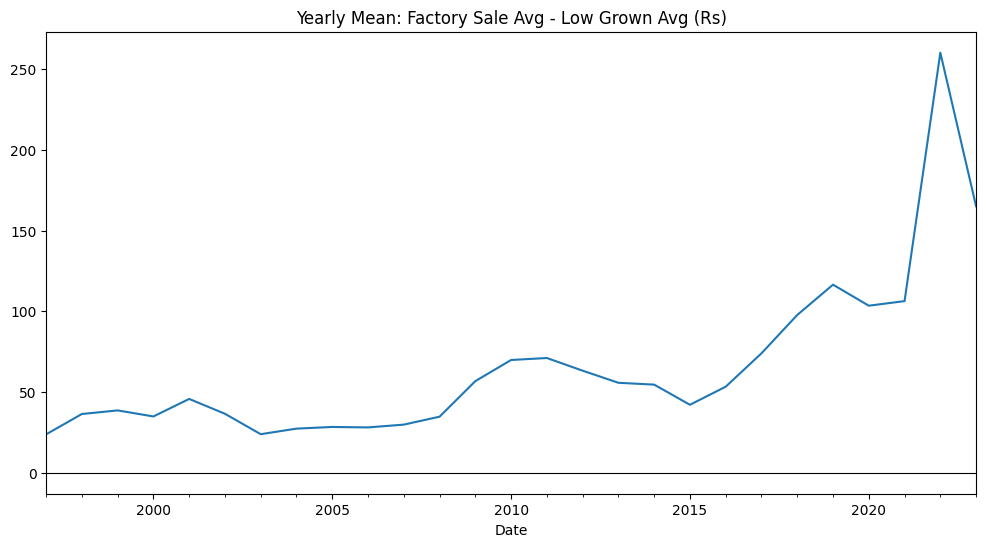

In [34]:
# 10. Factory vs Market Difference
# Purpose: Analyze the price difference between factory sale and low grown average.
df['DIFFERENCE (Rs)'].resample('Y').mean().plot(title='Yearly Mean: Factory Sale Avg - Low Grown Avg (Rs)')
plt.axhline(0, color='k', linewidth=0.8)
plt.show()

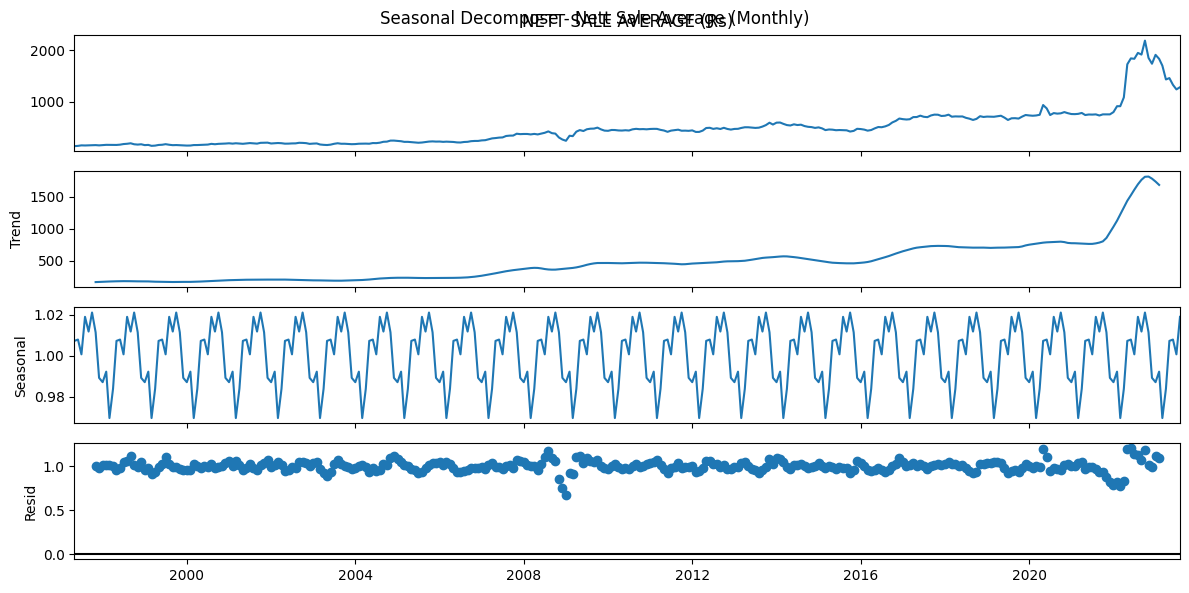

In [35]:
# 11. Seasonal / Cyclical Analysis
# Purpose: Detect seasonal patterns and cycles in prices and production.
monthly = df.resample('M').mean()
decomposition = seasonal_decompose(monthly['NETT SALE AVERAGE (Rs)'].dropna(), model='multiplicative', period=12)
decomposition.plot()
plt.suptitle('Seasonal Decompose - Nett Sale Average (Monthly)')
plt.show()

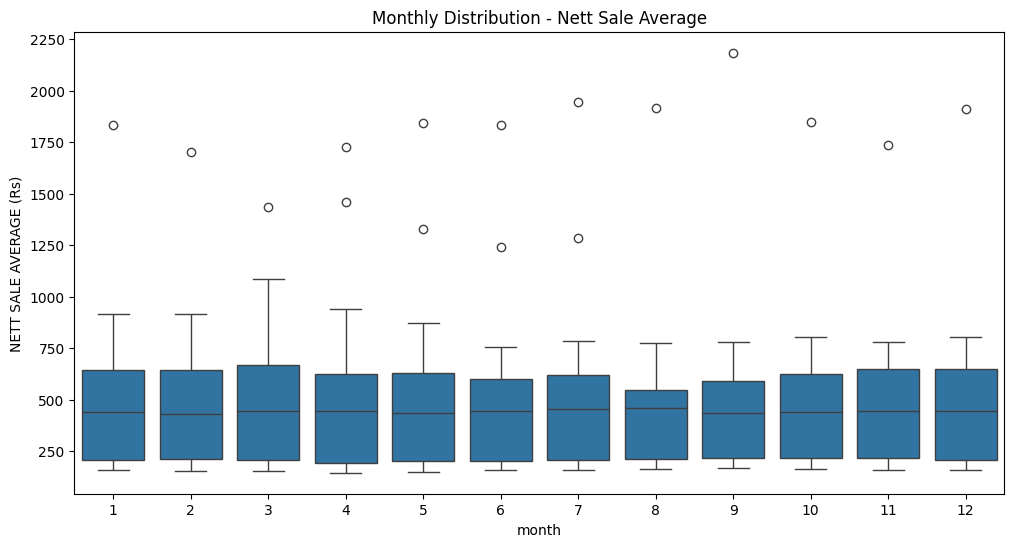

In [36]:
monthly['month'] = monthly.index.month
sns.boxplot(x='month', y='NETT SALE AVERAGE (Rs)', data=monthly.reset_index())
plt.title('Monthly Distribution - Nett Sale Average')
plt.show()

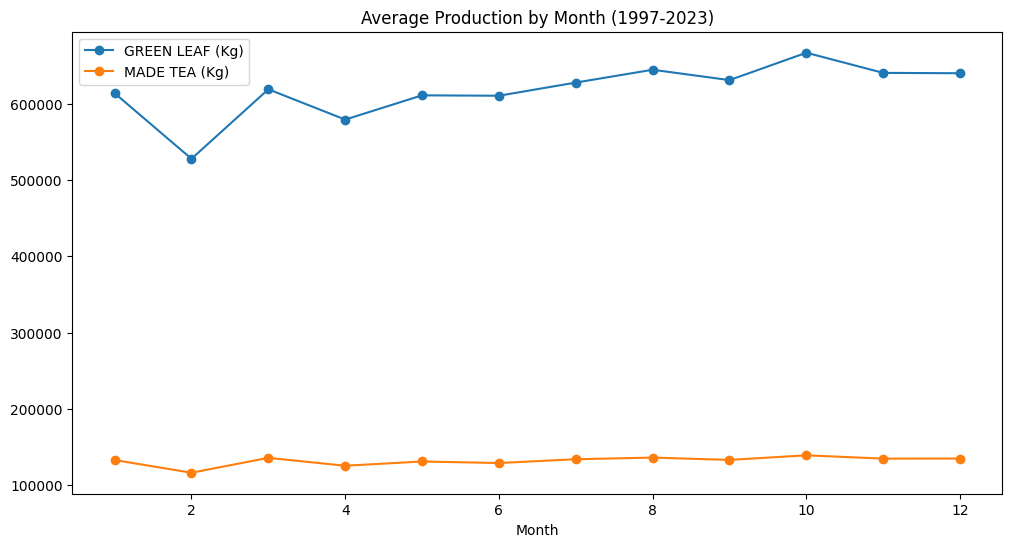

In [37]:
monthly[['GREEN LEAF (Kg)', 'MADE TEA (Kg)']].groupby(monthly.index.month).mean().plot(marker='o')
plt.title('Average Production by Month (1997-2023)')
plt.xlabel('Month')
plt.show()

In [39]:
# 12. Comparative & Performance Analysis
# Purpose: Identify best/worst years and estimate profitability yearly.
yearly_perf = df.resample('Y').agg({'MADE TEA (Kg)': 'sum', 'PROFIT_PER_KG': 'mean'})
yearly_perf['TOTAL_PROFIT_EST'] = yearly_perf['MADE TEA (Kg)'] * yearly_perf['PROFIT_PER_KG']
best_year = yearly_perf['TOTAL_PROFIT_EST'].idxmax().year
worst_year = yearly_perf['TOTAL_PROFIT_EST'].idxmin().year
print(f'Best year: {best_year}, Worst year: {worst_year}')
display(yearly_perf.sort_values('TOTAL_PROFIT_EST', ascending=False))

Best year: 2022, Worst year: 1997


,MADE TEA (Kg),PROFIT_PER_KG,TOTAL_PROFIT_EST
Date,,,
2022-12-31,1595381.5,1424.634167,2.272835e+09
2020-12-31,1820707.0,678.446667,1.235253e+09
2023-12-31,953604.0,1261.992857,1.203441e+09
2019-12-31,1965393.0,608.362500,1.195671e+09
2021-12-31,1795178.0,656.021667,1.177676e+09
2017-12-31,1817359.5,615.014167,1.117702e+09
2018-12-31,1803336.5,606.441667,1.093618e+09
2014-12-31,1839073.5,466.661667,8.582251e+08
2013-12-31,1862052.0,453.155000,8.437982e+08


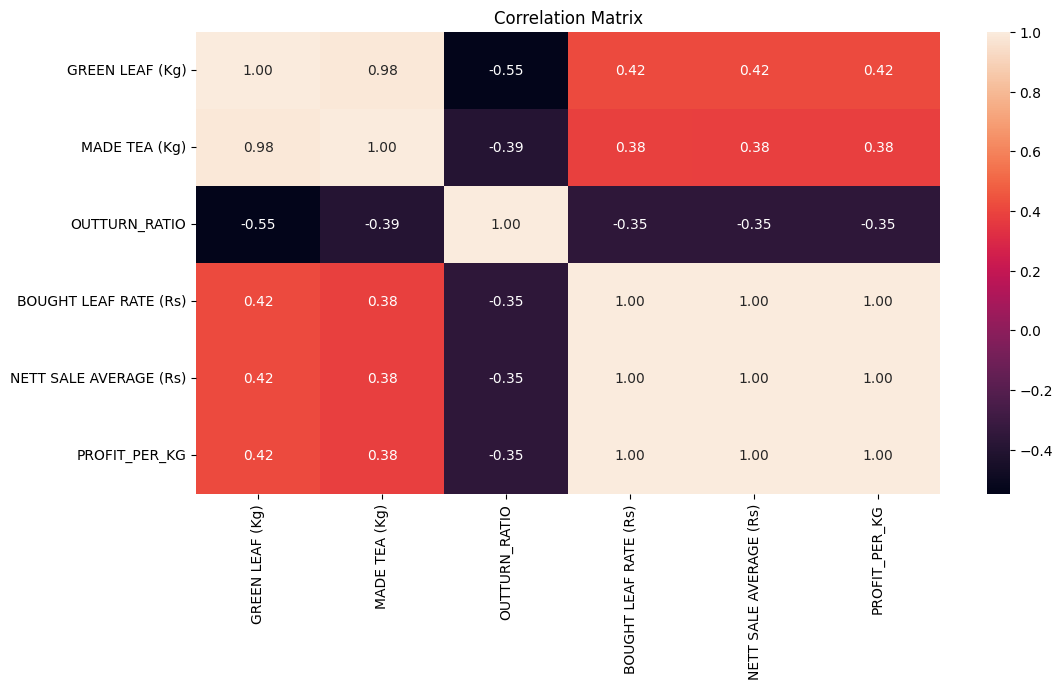

In [40]:
# 13. Correlation & Efficiency Analysis
# Purpose: Explore relationships between key metrics.
corr_matrix = df[['GREEN LEAF (Kg)', 'MADE TEA (Kg)', 'OUTTURN_RATIO', 'BOUGHT LEAF RATE (Rs)', 'NETT SALE AVERAGE (Rs)', 'PROFIT_PER_KG']].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

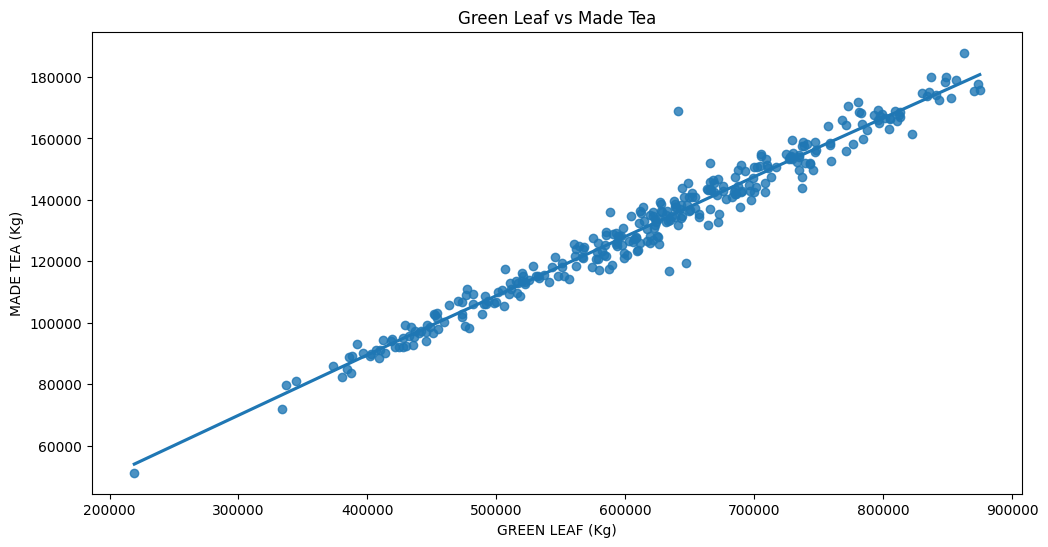

In [41]:
sns.regplot(x='GREEN LEAF (Kg)', y='MADE TEA (Kg)', data=df.dropna(), lowess=True)
plt.title('Green Leaf vs Made Tea')
plt.show()

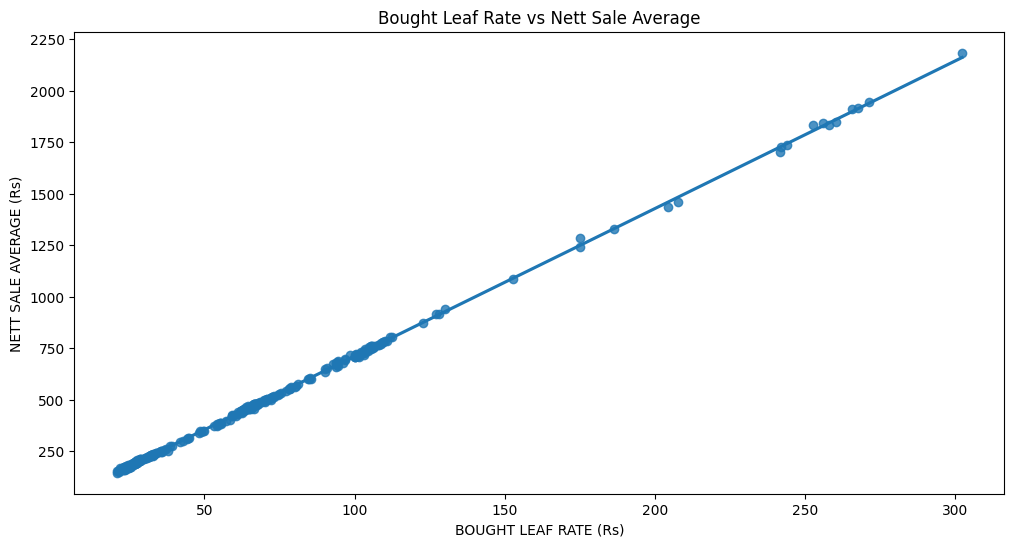

In [42]:
sns.regplot(x='BOUGHT LEAF RATE (Rs)', y='NETT SALE AVERAGE (Rs)', data=df.dropna(), lowess=True)
plt.title('Bought Leaf Rate vs Nett Sale Average')
plt.show()

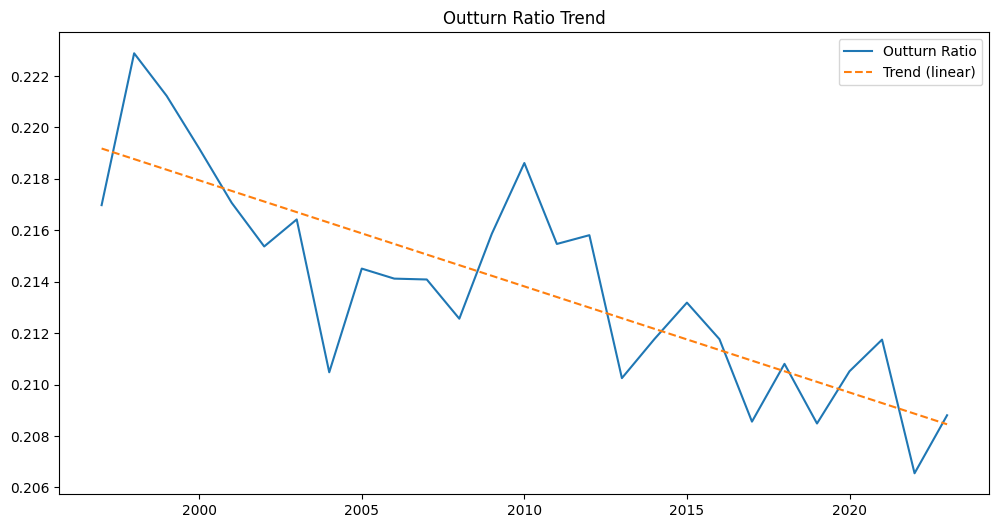

In [43]:
# 14. Outturn Trend Over Years
# Purpose: Detect long-term trend in conversion efficiency.
outturn_yearly = df['OUTTURN_RATIO'].resample('Y').mean().dropna()
X = np.arange(len(outturn_yearly)).reshape(-1,1)
lr = LinearRegression().fit(X, outturn_yearly.values)
trend_line = lr.predict(X)
plt.plot(outturn_yearly.index.year, outturn_yearly.values, label='Outturn Ratio')
plt.plot(outturn_yearly.index.year, trend_line, label='Trend (linear)', linestyle='--')
plt.legend()
plt.title('Outturn Ratio Trend')
plt.show()

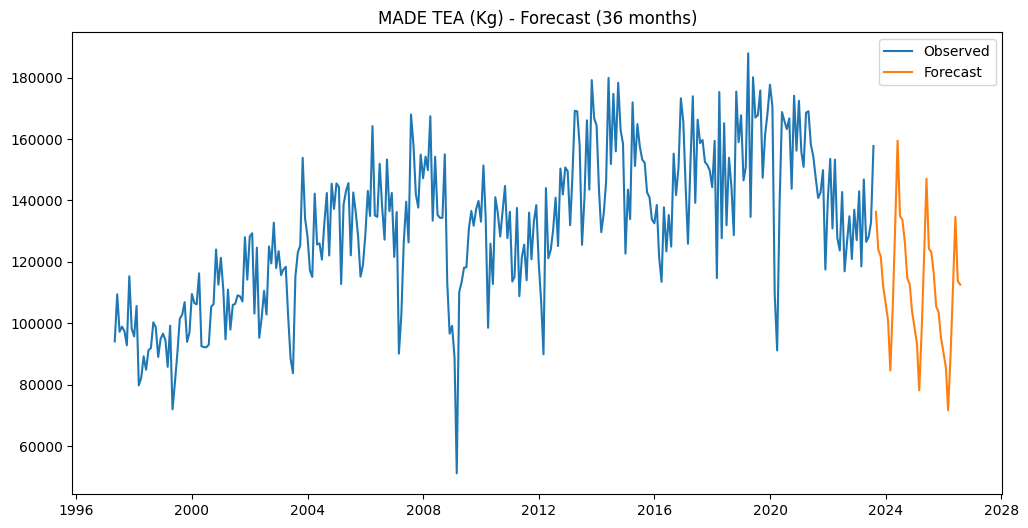

In [44]:
# 15. Forecasting & Projections
# Purpose: Forecast MADE TEA and NETT SALE AVERAGE for next 36 months using Holt-Winters method.
horizon = 36
series_made = monthly['MADE TEA (Kg)'].dropna()
hw_made = ExponentialSmoothing(series_made, trend='add', seasonal='mul', seasonal_periods=12).fit()
forecast_made = hw_made.forecast(horizon)
plt.plot(series_made.index, series_made.values, label='Observed')
plt.plot(forecast_made.index, forecast_made.values, label='Forecast')
plt.title('MADE TEA (Kg) - Forecast (36 months)')
plt.legend()
plt.show()

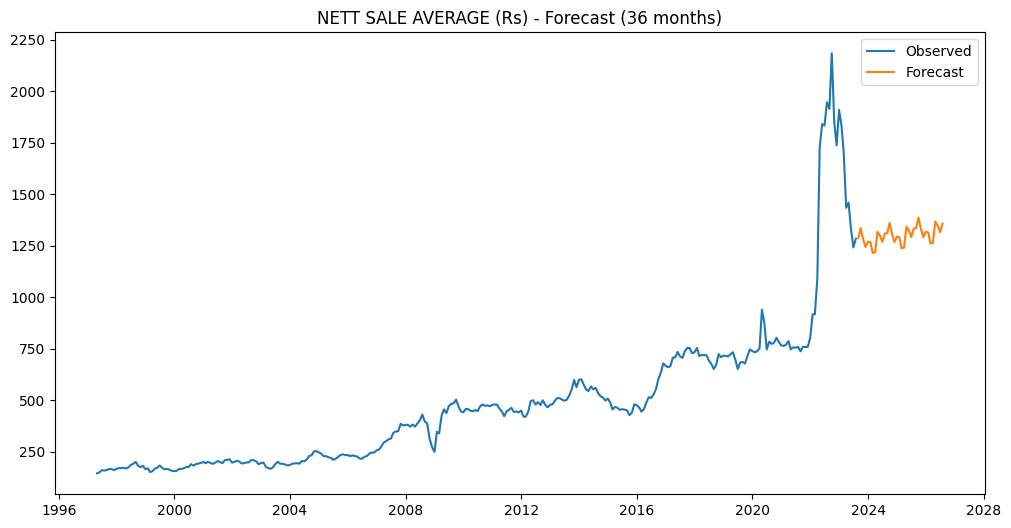

In [45]:
series_price = monthly['NETT SALE AVERAGE (Rs)'].dropna()
hw_price = ExponentialSmoothing(series_price, trend='add', seasonal='mul', seasonal_periods=12).fit()
forecast_price = hw_price.forecast(horizon)
plt.plot(series_price.index, series_price.values, label='Observed')
plt.plot(forecast_price.index, forecast_price.values, label='Forecast')
plt.title('NETT SALE AVERAGE (Rs) - Forecast (36 months)')
plt.legend()
plt.show()

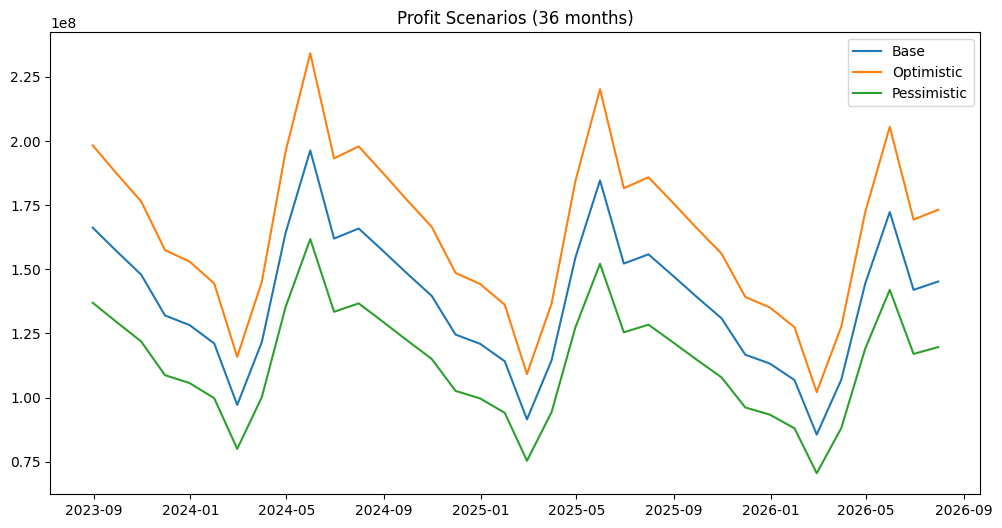

In [46]:
# 16. Scenario Analysis
# Purpose: Generate optimistic, base, and pessimistic scenarios for production and prices.
scenarios = pd.DataFrame(index=forecast_made.index)
scenarios['BASE_MADE_TEA'] = forecast_made
scenarios['OPT_MADE_TEA'] = forecast_made * 1.10
scenarios['PESS_MADE_TEA'] = forecast_made * 0.90


scenarios['BASE_PRICE'] = forecast_price
scenarios['OPT_PRICE'] = forecast_price * 1.08
scenarios['PESS_PRICE'] = forecast_price * 0.92


avg_bought = monthly['BOUGHT LEAF RATE (Rs)'].mean()
scenarios['BASE_PROFIT_EST'] = scenarios['BASE_MADE_TEA'] * (scenarios['BASE_PRICE'] - avg_bought)
scenarios['OPT_PROFIT_EST'] = scenarios['OPT_MADE_TEA'] * (scenarios['OPT_PRICE'] - avg_bought)
scenarios['PESS_PROFIT_EST'] = scenarios['PESS_MADE_TEA'] * (scenarios['PESS_PRICE'] - avg_bought)


scenarios.to_csv('scenarios_36m.csv')
plt.plot(scenarios.index, scenarios['BASE_PROFIT_EST'], label='Base')
plt.plot(scenarios.index, scenarios['OPT_PROFIT_EST'], label='Optimistic')
plt.plot(scenarios.index, scenarios['PESS_PROFIT_EST'], label='Pessimistic')
plt.title('Profit Scenarios (36 months)')
plt.legend()
plt.show()